# ORENIST Dynamic Filter Classification

Note: This notebook is desinged to run with CPU (no GPU) runtime.

This notebook uses TensorFlow2.x.

In [1]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import pickle

import tensorflow as tf
from tensorflow.keras import layers, models, initializers

random.seed(20230509)
np.random.seed(20190225)
tf.random.set_seed(20190225)

####[ODF-02]
Download the ORENIST dataset and store into NumPy arrays.

In [2]:
!curl -LO https://github.com/enakai00/colab_tfbook/raw/master/Chapter04/ORENIST.data
with open('ORENIST.data', 'rb') as file:
    images, labels = pickle.load(file)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  553k  100  553k    0     0   331k      0  0:00:01  0:00:01 --:--:--  331k


####[ODF-03]
Define a model to classify the ORENIST dataset with the convolutional filters.

The ouputs from filters are converted to a single pixel image with the pooling layer.

In [3]:
model = models.Sequential()
model.add(layers.Input(shape=(28*28,), name='input'))
model.add(layers.Reshape((28, 28, 1), name='reshape'))
model.add(layers.Conv2D(2, (5, 5), padding='same',
                        kernel_initializer=initializers.TruncatedNormal(),
                        use_bias=False, name='conv_filter'))
model.add(layers.Lambda(lambda x: abs(x), name='abs'))
model.add(layers.MaxPooling2D((28, 28), name='max_pooling'))
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(3, activation='softmax', name='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter (Conv2D)                 │ (None, 28, 28, 2)           │              50 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ abs (Lambda)                         │ (None, 28, 28, 2)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling (MaxPooling2D)           │ (None, 1, 1, 2)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, 3)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59 (236.00 B)

 Trainable params: 59 (236.00 B)

 Non-trainable params: 0 (0.00 B)

####[ODF-04]
Compile the model using the Adam optimizer, and Cross entroy as a loss function.

In [4]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

####[ODF-05]
Train the model.

In [5]:
%%time
history = model.fit(images, labels,
                    batch_size=len(images), epochs=2000, verbose=0)

CPU times: user 1min 5s, sys: 4.24 s, total: 1min 9s
Wall time: 1min 22s


####[ODF-06]
Plot charts to see the accuracy and loss values. It achieves the 100% accuracy.

<Axes: >

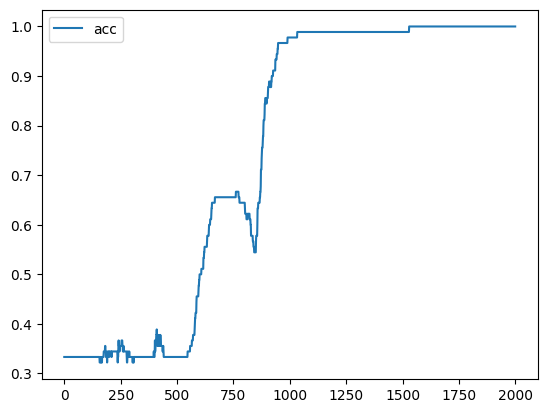

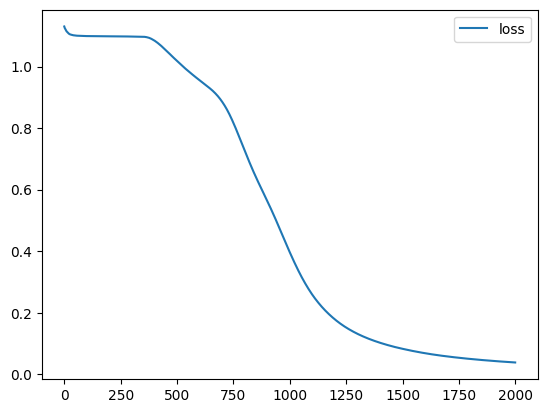

In [6]:
DataFrame({'acc': history.history['acc']}).plot()
DataFrame({'loss': history.history['loss']}).plot()

####[ODF-07]
Define a model to extract outputs from intermediate layers.

In [8]:
layer_outputs = [model.get_layer('abs').output,
                 model.get_layer('max_pooling').output]
model2 = models.Model(inputs=model.inputs[0], outputs=layer_outputs)

####[ODF-08]
Apply the trained filters to the ORENST dataset.

In [9]:
conv_output, pool_output = model2.predict(images[:9])
filter_vals = model.get_layer('conv_filter').get_weights()[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


####[ODF-09]
Show images after applying the convolutional filters.

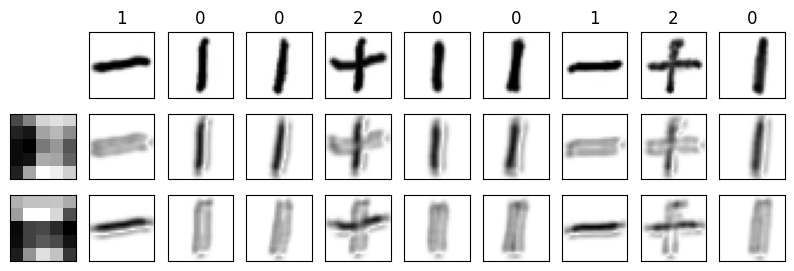

In [10]:
fig = plt.figure(figsize=(10, 3))
v_max = np.max(conv_output)

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:, :, 0, i], cmap=plt.cm.gray_r)

for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28, 28)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_output[i,:,:,0],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_output[i,:,:,1],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

####[ODF-10]
Show images after applying the pooling layer.

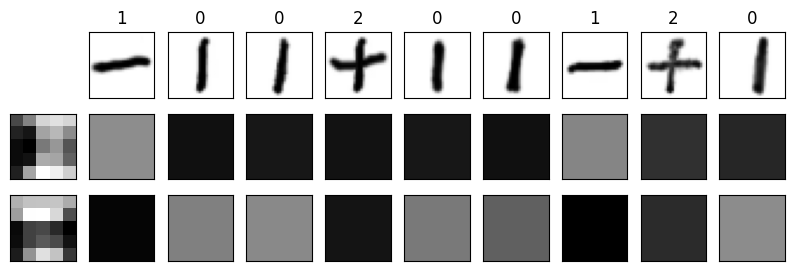

In [11]:
fig = plt.figure(figsize=(10, 3))
v_max = np.max(pool_output)


for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:, :, 0, i], cmap=plt.cm.gray_r)

for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28, 28)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_output[i, :, :, 0],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_output[i, :, :, 1],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

####[ODF-11]
Convert outputs from the pooling layer into binary values with a threshold 7.0.



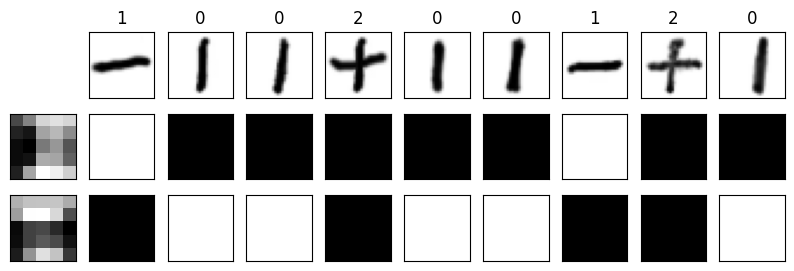

In [12]:
fig = plt.figure(figsize=(10, 3))
bin_index = np.sign(pool_output-7.0)

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:, :, 0, i], cmap=plt.cm.gray_r)

for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28, 28)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(bin_index[i, :, :, 0],
                   vmin=-1, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(bin_index[i, :, :, 1],
                   vmin=-1, vmax=1, cmap=plt.cm.gray_r)